In [1]:
import netCDF4 as nc
import sys, os, argparse
import time
import numpy as np
from numpy import ma as ma

#Import packages for plotting
from matplotlib import pyplot as plt
from matplotlib import colors as mcolors
import matplotlib.animation as animation
from matplotlib.ticker import MaxNLocator
from pylab import imshow,cm

#Import packages for clustering
from sklearn.cluster import KMeans
from scipy.linalg import eigh

#Import packages for geodesic distences
from pyproj import Geod

from scipy.interpolate import griddata
from matplotlib.path import Path

#Import packages for interpolating and filtering data
from scipy.spatial import ConvexHull, convex_hull_plot_2d
from scipy.interpolate import LinearNDInterpolator as LNDI

# Import package for parallel computing
from joblib import Parallel, delayed

parent_directory = "/cluster/home/llpui9007/Programs/HPC_Spectral_Clustering"
sys.path.append(parent_directory+"/subfunctions/Parallelisation")
from parallelised_functions import split3D

sys.path.append(parent_directory+"/subfunctions/trajectory_advection")
from Interpolant import generate_land_mask_interpolator 

In [2]:
def ini_final_clusters_landmask_borders(Fmap, n_clusters, labels, img_name, e, x, y, mask_interpol, scalar):
    positions_ini = Fmap[0, :, :]
    positions_end = Fmap[-1, :, :]

    ymax = y.max()
    ymin = y.min()
    xmax = x.max()
    xmin = x.min()

    fig, axes = plt.subplots(1, 2, figsize=(16, 8), sharex=True, sharey=True)
    # Define a color map for the clusters
    colors = plt.get_cmap("tab20", n_clusters)
    cluster_names = [f"Cluster {i+1}" for i in range(n_clusters)]  # Names for legend
    # Define color map for the landmask
    colors_mask = [(0.58, 0.747, 0.972), (1, 1, 1)]  # Light blue and white
    custom_cmap = mcolors.LinearSegmentedColormap.from_list("GreyToBlue", colors_mask)
    colors_mask = plt.get_cmap(custom_cmap, 2)
    # Interpolate the labels onto the grid
    grid_labels_ini = griddata((positions_ini[0, :], positions_ini[1, :]), labels, (x,y), method='nearest')
    grid_labels_end = griddata((positions_end[0, :], positions_end[1, :]), labels, (x,y), method='nearest')
    fmap_mask_end = np.isnan(griddata((positions_end[0, :], positions_end[1, :]), labels, (x,y), method='linear'))
    fmap_mask_ini = np.isnan(griddata((positions_ini[0, :], positions_ini[1, :]), labels, (x,y), method='linear'))

    borders_end = borders_binary(grid_labels_end)
    borders_end = np.where(fmap_mask_end,np.nan, borders_end)
    borders_end = np.ma.masked_where(borders_end==0, borders_end)

    borders_ini = borders_binary(grid_labels_ini)
    borders_ini = np.where(fmap_mask_ini, np.nan, borders_ini)
    borders_ini = np.ma.masked_where(borders_ini == 0, borders_ini)

    # First subplot
    scalar_ini = scalar[0, :, :]  # Assuming you want to show the first time slice
    #axes[0].pcolor(x,y,fmap_mask,cmap="Greys",alpha=1)

    #axes[0].pcolormesh(x, y, scalar_ini, cmap="bone_r", alpha=1)
    im1 = axes[0].imshow(scalar_ini, extent=(xmin, xmax, ymin, ymax), origin='lower', cmap='bone_r')
    axes[0].pcolormesh(x,y,borders_ini,cmap="Greys",alpha=1)
    scatter_ini = axes[0].scatter(positions_ini[0, :], positions_ini[1, :], c=labels, cmap=colors, vmin=0, vmax=n_clusters-1, s=4)
    contour_land = axes[0].contour(x, y, mask_interpol, levels=0, cmap='bone', alpha=1)

    #im1 = axes[0].imshow(masked_borders_ini, extent=(xmin, xmax, ymin, ymax), origin='lower', cmap='bone_r', alpha=0.7)

    # Add contour plot to the first subplot
    #contour_land = axes[0].contour(x, y, mask_interpol, levels=1, cmap='viridis', alpha=0.5)
    axes[0].set_xlabel("Rotated Longitude")
    axes[0].set_ylabel("Rotated Latitude")
    axes[0].set_title("Initial distribution of the clusters")
    axes[0].set_xlim(xmin-0.05*(xmax-xmin), xmax+0.05*(xmax-xmin)) 
    axes[0].set_ylim(ymin-0.05*(xmax-xmin), ymax+0.05*(ymax-ymin))  
    axes[0].set_aspect('equal', 'box')
    # Add contour lines to show label changes

    # Second subplot
    scalar_end = scalar[0, :, :]  # Assuming you want to show the first time slice


    im1 = axes[1].imshow(scalar_end, extent=(xmin, xmax, ymin, ymax), origin='lower', cmap='bone_r')
    #axes[1].pcolormesh(x, y, scalar_end, cmap="bone_r", alpha=1)
    axes[1].pcolor(x,y,borders_end,cmap="Greys",alpha=1)

    scatter_end = axes[1].scatter(positions_end[0, :], positions_end[1, :], c=labels, cmap=colors, vmin=0, vmax=n_clusters-1, s=4)
    contour_land = axes[1].contour(x, y, mask_interpol, levels=0, cmap='bone', alpha=1)
    #im1 = axes[0].imshow(masked_borders_ini, extent=(xmin, xmax, ymin, ymax), origin='lower', cmap='bone_r', alpha=0.7)

    # Add contour plot to the first subplot
    #contour_land = axes[0].contour(x, y, mask_interpol, levels=1, cmap='viridis', alpha=0.5)
    axes[1].set_xlabel("Rotated Longitude")
    axes[1].set_ylabel("Rotated Latitude")
    axes[1].set_title("Initial distribution of the clusters")
    axes[1].set_xlim(xmin-0.05*(xmax-xmin), xmax+0.05*(xmax-xmin)) 
    axes[1].set_ylim(ymin-0.05*(xmax-xmin), ymax+0.05*(ymax-ymin))  
    axes[1].set_aspect('equal', 'box')
    # Add contour lines to show label changes 

    # Add legend
    #handles = [plt.Line2D([0], [0], marker='o', color='w', label=cluster_names[j],markerfacecolor=colors(j), markersize=8) for j in range(n_clusters)]
    #axes[1].legend(handles=handles, loc="upper left", bbox_to_anchor=(1, 1))
    cbar = fig.colorbar(im1, ax=[axes[0], axes[1]], orientation='vertical', fraction=0.046, pad=0.04)
    #cbar = plt.colorbar(im1, orientation='vertical')
    cbar.set_label('Colorbar Label')  # Optional: add a label to the colorbar
    # Main title
    plt.suptitle(f"{n_clusters} clusters_{e} spars", fontsize=16)
    plt.subplots_adjust(right=0.8) 
    # Save the figure
    plt.savefig(f"{img_name}")
    # Show the plot
    plt.show()
   

In [3]:
def gif_clusters_landmask_borders(Fmap, n_clusters, labels, img_name, e, x, y, mask_interpol, scalar, freq):
    
    fig, ax = plt.subplots(figsize=(8, 6))
    # Define a color map for the clusters
    colors = plt.get_cmap("tab20", n_clusters)
    cluster_names = [f"Cluster {i+1}" for i in range(n_clusters)]  # Names for legend
    # Define color map for the landmask
    colors_mask = [(0.58, 0.747, 0.972), (1, 1, 1)]  # Light blue and white
    custom_cmap = mcolors.LinearSegmentedColormap.from_list("GreyToBlue", colors_mask)
    colors_mask = plt.get_cmap(custom_cmap, 2)
    ymax = y.max()
    ymin = y.min()
    xmax = x.max()
    xmin = x.min()


    # Create a grid for contour plotting
    grid_x, grid_y = np.meshgrid(np.linspace(xmin, xmax, 50), np.linspace(ymin, ymax, 50))
    
    # Plot the static landmask once
    ax.scatter(x.ravel(), y.ravel(), marker='.', s=0.1, c=mask_interpol, cmap=colors_mask)

    # Set axis limits and labels
    ax.set_xlim(xmin - 0.08 * (xmax - xmin), xmax + 0.08 * (xmax - xmin))
    ax.set_ylim(ymin - 0.08 * (ymax - ymin), ymax + 0.08 * (ymax - ymin))
    ax.set_xlabel("Degrees W")
    ax.set_ylabel("Degrees E")
    ax.set_aspect('equal', 'box')

    # Create the legend once
    #handles = [plt.Line2D([0], [0], marker='o', color='w', label=cluster_names[j],markerfacecolor=colors(j), markersize=8) for j in range(n_clusters)]
    #ax.legend(handles=handles, loc="upper left", bbox_to_anchor=(1.05, 1))

    # Define a color map for the clusters
    colors = plt.get_cmap("tab20", n_clusters)
    cluster_names = [f"Cluster {i+1}" for i in range(n_clusters)]  # Names for legend
    # Define color map for the landmask
    colors_mask = [(0.58, 0.747, 0.972), (1, 1, 1)]  # Light blue and white
    custom_cmap = mcolors.LinearSegmentedColormap.from_list("GreyToBlue", colors_mask)
    colors_mask = plt.get_cmap(custom_cmap, 2)
    # Interpolate the labels onto the grid
    
    def animate(i):
        # Remove previous trajectory scatter plots
        # Keep only the first collection (landmask)
        while len(ax.collections) > 1:
            ax.collections[-1].remove()
    
        positions_i = Fmap[i*freq, :, :]
        scalar_i = scalar[i, :, :]  # Assuming you want to show the first time slice

        grid_labels = griddata((positions_i[0, :], positions_i[1, :]), labels, (x,y), method='nearest')
        fmap_mask = np.isnan(griddata((positions_i[0, :], positions_i[1, :]), labels, (x,y), method='linear'))

        borders = borders_binary(grid_labels)
        borders = np.where(fmap_mask,np.nan, borders)
        borders = np.ma.masked_where(borders==0, borders)

        #ax.pcolor(x,y,fmap_mask,cmap="Greys",alpha=1)
        #ax.pcolormesh(x, y, scalar_ini, cmap="bone_r", alpha=1)
        im1 = ax.imshow(scalar_i, extent=(xmin, xmax, ymin, ymax), origin='lower', cmap='bone_r')
        ax.pcolormesh(x,y,borders,cmap="Greys",alpha=1)
        scatter_ini = ax.scatter(positions_i[0, :], positions_i[1, :], c=labels, cmap=colors, vmin=0, vmax=n_clusters-1, s=4)
        contour_land = ax.contour(x, y, mask_interpol, levels=0, cmap='bone', alpha=1)

        # Add contour plot to the first subplot
        #contour_land = axes[0].contour(x, y, mask_interpol, levels=1, cmap='viridis', alpha=0.5)
        ax.set_xlabel("Rotated Longitude")
        ax.set_ylabel("Rotated Latitude")
        ax.set_xlim(xmin-0.05*(xmax-xmin), xmax+0.05*(xmax-xmin)) 
        ax.set_ylim(ymin-0.05*(xmax-xmin), ymax+0.05*(ymax-ymin))  
        ax.set_aspect('equal', 'box')
        ax.set_title(f"Cluster at timestep {i + 1}")
        return im1,

    # Filter frames to include only multiples of freq
    frames_to_plot = [int(i/freq) for i in range(Fmap.shape[0]) if i % freq == 0]

    #Fmap.shape[0]
    
    # Create the animation
    ani = animation.FuncAnimation(fig, animate, frames=frames_to_plot, repeat=False, blit=True)

    # Adjust layout to fit legend
    plt.subplots_adjust(right=0.8)

    # Save the animation as a GIF
    ani.save(img_name, writer='pillow', fps=10)
    print(f"Animation saved to {img_name}")

    plt.close(fig)

In [4]:
def gif_clusters_landmask_borders_noscat(Fmap, n_clusters, labels, img_name, e, x, y, mask_interpol, scalar, freq):
    
    fig, ax = plt.subplots(figsize=(8, 6))
    # Define a color map for the clusters
    colors = plt.get_cmap("tab20", n_clusters)
    cluster_names = [f"Cluster {i+1}" for i in range(n_clusters)]  # Names for legend
    # Define color map for the landmask
    colors_mask = [(0.58, 0.747, 0.972), (1, 1, 1)]  # Light blue and white
    custom_cmap = mcolors.LinearSegmentedColormap.from_list("GreyToBlue", colors_mask)
    colors_mask = plt.get_cmap(custom_cmap, 2)
    ymax = y.max()
    ymin = y.min()
    xmax = x.max()
    xmin = x.min()


    # Create a grid for contour plotting
    grid_x, grid_y = np.meshgrid(np.linspace(xmin, xmax, 50), np.linspace(ymin, ymax, 50))
    
    # Plot the static landmask once
    ax.scatter(x.ravel(), y.ravel(), marker='.', s=0.1, c=mask_interpol, cmap=colors_mask)

    # Set axis limits and labels
    ax.set_xlim(xmin - 0.08 * (xmax - xmin), xmax + 0.08 * (xmax - xmin))
    ax.set_ylim(ymin - 0.08 * (ymax - ymin), ymax + 0.08 * (ymax - ymin))
    ax.set_xlabel("Degrees W")
    ax.set_ylabel("Degrees E")
    ax.set_aspect('equal', 'box')

    # Create the legend once
    #handles = [plt.Line2D([0], [0], marker='o', color='w', label=cluster_names[j],markerfacecolor=colors(j), markersize=8) for j in range(n_clusters)]
    #ax.legend(handles=handles, loc="upper left", bbox_to_anchor=(1.05, 1))

    # Define a color map for the clusters
    colors = plt.get_cmap("tab20", n_clusters)
    cluster_names = [f"Cluster {i+1}" for i in range(n_clusters)]  # Names for legend
    # Define color map for the landmask
    colors_mask = [(0.58, 0.747, 0.972), (1, 1, 1)]  # Light blue and white
    custom_cmap = mcolors.LinearSegmentedColormap.from_list("GreyToBlue", colors_mask)
    colors_mask = plt.get_cmap(custom_cmap, 2)
    # Interpolate the labels onto the grid
    
    def animate(i):
        # Remove previous trajectory scatter plots
        # Keep only the first collection (landmask)
        while len(ax.collections) > 1:
            ax.collections[-1].remove()
    
        positions_i = Fmap[i*freq, :, :]
        scalar_i = scalar[i, :, :]  # Assuming you want to show the first time slice

        grid_labels = griddata((positions_i[0, :], positions_i[1, :]), labels, (x,y), method='nearest')
        fmap_mask = np.isnan(griddata((positions_i[0, :], positions_i[1, :]), labels, (x,y), method='linear'))

        borders = borders_binary(grid_labels)
        borders = np.where(fmap_mask,np.nan, borders)
        borders = np.ma.masked_where(borders==0, borders)

        #ax.pcolor(x,y,fmap_mask,cmap="Greys",alpha=1)
        #ax.pcolormesh(x, y, scalar_ini, cmap="bone_r", alpha=1)
        im1 = ax.imshow(scalar_i, extent=(xmin, xmax, ymin, ymax), origin='lower', cmap='bone_r')
        #ax.pcolormesh(x,y,borders,cmap="Greys",alpha=1)
        #scatter_ini = ax.scatter(positions_i[0, :], positions_i[1, :], c=labels, cmap=colors, vmin=0, vmax=n_clusters-1, s=4)
        contour_land = ax.contour(x, y, mask_interpol, levels=0, cmap='bone', alpha=1)

        # Add contour plot to the first subplot
        #contour_land = axes[0].contour(x, y, mask_interpol, levels=1, cmap='viridis', alpha=0.5)
        ax.set_xlabel("Rotated Longitude")
        ax.set_ylabel("Rotated Latitude")
        ax.set_xlim(xmin-0.05*(xmax-xmin), xmax+0.05*(xmax-xmin)) 
        ax.set_ylim(ymin-0.05*(xmax-xmin), ymax+0.05*(ymax-ymin))  
        ax.set_aspect('equal', 'box')
        ax.set_title(f"Cluster at timestep {i + 1}")
        return im1,

    # Filter frames to include only multiples of freq
    frames_to_plot = [int(i/freq) for i in range(Fmap.shape[0]) if i % freq == 0]

    #Fmap.shape[0]
    
    # Create the animation
    ani = animation.FuncAnimation(fig, animate, frames=frames_to_plot, repeat=False, blit=True)

    # Adjust layout to fit legend
    plt.subplots_adjust(right=0.8)

    # Save the animation as a GIF
    ani.save(img_name, writer='pillow', fps=10)
    print(f"Animation saved to {img_name}")

    plt.close(fig)

In [20]:
def kmeans(n_clusters, l_vect,sit,geodesic,e,Fmap):
    print("Applying k-means to define the clusters")
    Cluster_params = (
        f"geodesic_{geodesic}_"
        f"nclusters{n_clusters}_"
        f"e{e:.2f}"
    )

    l_vect_cut = l_vect[:,0:n_clusters]
    kmeans = KMeans(init="random",n_clusters=n_clusters,n_init=1000,max_iter=10000)
    kmeans.fit(l_vect_cut)
    labels = kmeans.labels_

    np.save(results_directory+'/Clusters_labels_'+Cluster_params+'.npy', labels)
    np.save(results_directory+'/Fmap_'+Cluster_params+'.npy', Fmap)

    print("Plotting the clusters")
    #ini_final_clusters(Fmap, n_clusters, labels, results_directory, "", e)
    ini_final_clusters_landmask_borders(Fmap, n_clusters, labels, results_directory+"clusters"+Cluster_params+".png", e, longitude, latitude, land_mask,sit)
    gif_clusters_landmask_borders(Fmap, n_clusters, labels, results_directory+"clusters"+Cluster_params+".gif", e, longitude, latitude, land_mask,sit,10)
    #gif_clusters_landmask_borders_noscat(Fmap, n_clusters, labels, results_directory+"clusters"+Cluster_params+"_noscat.mp4", e, longitude, latitude, land_mask,sit,10)
    return 0


In [6]:
IC_resolution = 0.5
dt = 0.0025
DT = 0.025
K=1000
k_exp=20


formatted_DT = f"{DT:.4f}"
formatted_dt = f"{dt:.4f}"

special_name = "beaufort_zoom_lead_febmars"
filename = f"OPA-neXtSIM_CREG025_ILBOXE140_2010_ice_90Rx_{special_name}_regrided.nc"

Fmap_params = f"ic{IC_resolution}_"
Fmap_params += f"dt{formatted_dt}_"
Fmap_params += f"DT{formatted_DT}"


directory = f"/cluster/projects/nn8008k/lluisa/NextSIM/rotated_ice_velocities/special_cases/{special_name}/"
file_path = f"{directory}Fmap/{Fmap_params}/"
parent_directory = "/cluster/home/llpui9007/Programs/HPC_Spectral_Clustering"
results_directory = file_path


geo_file_path = f"{directory}{filename}"

if not os.path.exists(results_directory):
    os.makedirs(results_directory)


# add utils folder to the TBarrier package
#sys.path.append(T_Barrier_directory+"/subfunctions/utils")
#sys.path.append(T_Barrier_directory+"/subfunctions/integration")
# add utils folder to current working path
sys.path.append(parent_directory+"/subfunctions/Similarity_matrix_clustering")
sys.path.append(parent_directory+"/subfunctions/border_calculation")
sys.path.append(parent_directory+"/utils")


from from_similarity_to_eigen import from_similarity_to_eigen, from_similarity_to_eigen_cut

from ploters import ini_final_clusters
from ploters import gif_clusters
from ploters import ini_final_clusters_landmask
from ploters import gif_clusters_landmask
from calculating_borders import borders_binary


dataset = nc.Dataset(geo_file_path, mode='r')

#from m/s to m/day
land_mask = dataset.variables['land_mask'][:]
sit = dataset.variables['sit'][:,:,:]

# Access coordinates
latitude = dataset.variables['regrided_rot_lat'][:]  
longitude = dataset.variables['regrided_rot_lon'][:]

dataset.close()


In [7]:
e=0
geodesic=True


In [8]:
Fmap_path = file_path+'/Fmap_matrix.npy'
time_path = file_path+'/advection_time.npy'


# Load the Fmap array from the file
Fmap = np.load(Fmap_path)  # ntime [lon,lat] ntrajectories
#Fmap=Fmap[:,:,::100]
# Load the time_adv_mod array from the file
time_adv_mod = np.load(time_path)

formatted_e = f"{e:.2f}"
n_clusters = 0
Cluster_params = f"geodesic_{geodesic}_e{formatted_e}"

W_params = (
    f"geodesic_{geodesic}"
)
W_path = file_path+'/W_matrix_'+W_params+'.npy'
# Load the similarity matrix
W_vec = np.load(W_path)

print("Computing the eigenvalues")
if e==0:
    e = np.std(W_vec[W_vec<999])
    


Computing the eigenvalues


In [9]:
W_vec.shape

(137026,)

In [10]:

n=Fmap.shape[2]
indices = np.tril_indices(n,0,n)
print("The percentage of spercified elements is "+str(np.sum(W_vec < e)/np.sum(W_vec)))
W_vec[W_vec < e] = 0

# Create an empty matrix of zeros with shape (n, n)
W = np.zeros((n, n))
W[indices] = W_vec
# Fill the upper triangular part 
W = W + W.T - np.diag(np.diag(W))


The percentage of spercified elements is 0.19223326953036898


In [11]:
from scipy.ndimage import binary_dilation
# Define the number of cells to expand the mask
distance = 4
# Create a structuring element for dilation
structuring_element = np.ones((2 * distance + 1, 2 * distance + 1))
# Perform binary dilation to expand the mask
expanded_land_mask = binary_dilation(land_mask, structure=structuring_element)

exp_land_mask = generate_land_mask_interpolator(latitude,longitude,expanded_land_mask)
Fmap_mask = exp_land_mask(Fmap[:,1,:],Fmap[:,0,:])
IC_mask = np.sum(Fmap_mask,axis=0)

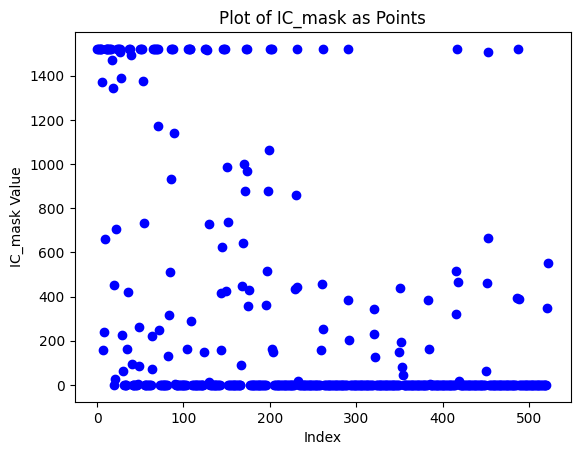

In [12]:
indices = np.arange(len(IC_mask))
# Plot using plot with linestyle set to 'none'
plt.plot(indices, IC_mask, 'o', linestyle='none', color='blue')
# Add labels and title
plt.xlabel('Index')
plt.ylabel('IC_mask Value')
plt.title('Plot of IC_mask as Points')
# Show the plot
plt.show()

In [13]:
IC_mask_final = np.where(IC_mask > 0)[0]

In [14]:
Fmap_cut = np.delete(Fmap, IC_mask_final, axis=2)

In [15]:
Fmap_cut.shape

(1521, 2, 382)

In [16]:
W_cut = np.delete(W, IC_mask_final, axis=0)  # Remove rows
W_cut = np.delete(W_cut, IC_mask_final, axis=1) 

In [17]:
def results(e,geodesic,file_path,K,k_exp,scalar):
    print("Reading data")
    #Read input data
    Fmap_path = file_path+'/Fmap_matrix.npy'
    time_path = file_path+'/advection_time.npy'


    # Load the Fmap array from the file
    Fmap = np.load(Fmap_path)  # ntime [lon,lat] ntrajectories
    #Fmap=Fmap[:,:,::100]
    # Load the time_adv_mod array from the file
    time_adv_mod = np.load(time_path)

    formatted_e = f"{e:.2f}"
    n_clusters = 0
    Cluster_params = f"geodesic_{geodesic}_e{formatted_e}"

    W_params = (
        f"geodesic_{geodesic}"
    )
    W_path = file_path+'/W_matrix_'+W_params+'.npy'
    # Load the similarity matrix
    W_vec = np.load(W_path)

    print("Computing the eigenvalues")
    if e==0:
        e = np.std(W_vec[W_vec<999])

    fig, axes = plt.subplots(1, 2, figsize=(14, 4))
    axes[0].plot(W_vec[W_vec<999], color = 'black', label="No_spars")
    axes[0].axhline(y=e, color='yellow', linestyle='--', label=f'e = {e}')
    axes[0].legend()

    l_vect,l,Fmap,n_clusters_def = from_similarity_to_eigen(Fmap, W_vec, e, K, k_exp)

    lx = np.arange(1, len(l) + 1)
    axes[1].plot(lx,l,marker='.',color='red',label=str(k_exp)+" first eigenvalues")
    axes[1].axvline(x=n_clusters_def, color="green",label="default number of clusters")
    axes[1].legend()
    axes[1].xaxis.set_major_locator(MaxNLocator(integer=True))
    axes[1].set_xlabel("Index")
    axes[1].set_ylabel("Generalised eigenvalues")
    plt.show()
    #plt.savefig(results_directory+"eigenvalues_"+Cluster_params+".png")

    kmeans(4,l_vect,scalar,geodesic,e,Fmap)
    #kmeans(8,l_vect,scalar,geodesic,e,Fmap)
    #kmeans(12,l_vect,scalar,geodesic,e,Fmap)
    #kmeans(16,l_vect,scalar,geodesic,e,Fmap)

    return 0

In [18]:
def results_cut(e,geodesic,file_path,K,k_exp,scalar,distance,land_mask,latitude,longitude):
    print("Reading data")
    #Read input data
    Fmap_path = file_path+'/Fmap_matrix.npy'
    time_path = file_path+'/advection_time.npy'


    # Load the Fmap array from the file
    Fmap = np.load(Fmap_path)  # ntime [lon,lat] ntrajectories
    #Fmap=Fmap[:,:,::100]
    # Load the time_adv_mod array from the file
    time_adv_mod = np.load(time_path)

    formatted_e = f"{e:.2f}"
    n_clusters = 0
    Cluster_params = f"geodesic_{geodesic}_e{formatted_e}"

    W_params = (
        f"geodesic_{geodesic}"
    )
    W_path = file_path+'/W_matrix_'+W_params+'.npy'
    # Load the similarity matrix
    W_vec = np.load(W_path)

    print("Computing the eigenvalues")
    if e==0:
        e = np.std(W_vec[W_vec<999])

    fig, axes = plt.subplots(1, 2, figsize=(14, 4))
    axes[0].plot(W_vec[W_vec<999], color = 'black', label="No_spars")
    axes[0].axhline(y=e, color='yellow', linestyle='--', label=f'e = {e}')
    axes[0].legend()

    l_vect,l,Fmap,n_clusters_def = from_similarity_to_eigen_cut(Fmap, W_vec, e, K, k_exp,distance,land_mask,latitude,longitude)

    lx = np.arange(1, len(l) + 1)
    axes[1].plot(lx,l,marker='.',color='red',label=str(k_exp)+" first eigenvalues")
    axes[1].axvline(x=n_clusters_def, color="green",label="default number of clusters")
    axes[1].legend()
    axes[1].xaxis.set_major_locator(MaxNLocator(integer=True))
    axes[1].set_xlabel("Index")
    axes[1].set_ylabel("Generalised eigenvalues")
    plt.show()
    #plt.savefig(results_directory+"eigenvalues_"+Cluster_params+".png")

    #kmeans(4,l_vect,scalar,geodesic,e,Fmap)
    #kmeans(8,l_vect,scalar,geodesic,e,Fmap)
    #kmeans(12,l_vect,scalar,geodesic,e,Fmap)
    kmeans(16,l_vect,scalar,geodesic,e,Fmap)

    return 0

Reading data
Computing the eigenvalues
The percentage of spercified elements is 0.24479058154452119
(141,) trajectories have been removed because they were too close to land or ending up too close to land
(0,) trajectories have been removed because they were not similar to any other trajectories
Computing first 20 eigenvalues
k_means clustering
The default number of clusters is 16


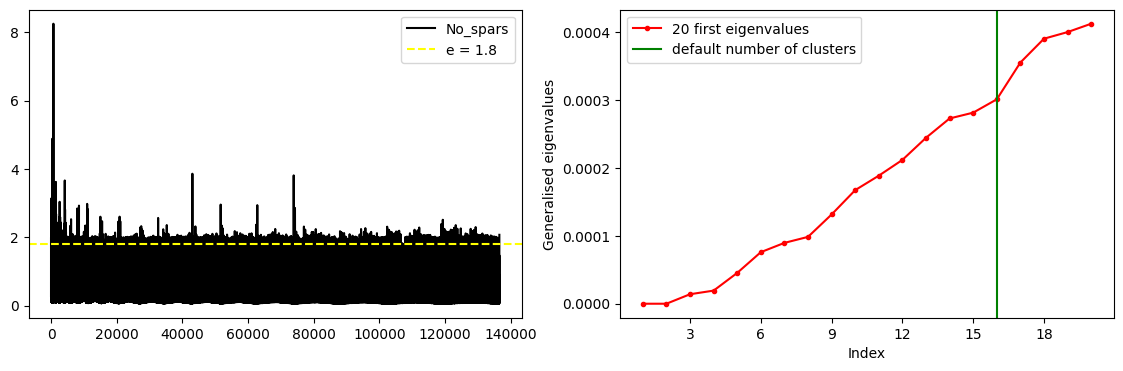

Applying k-means to define the clusters
Plotting the clusters


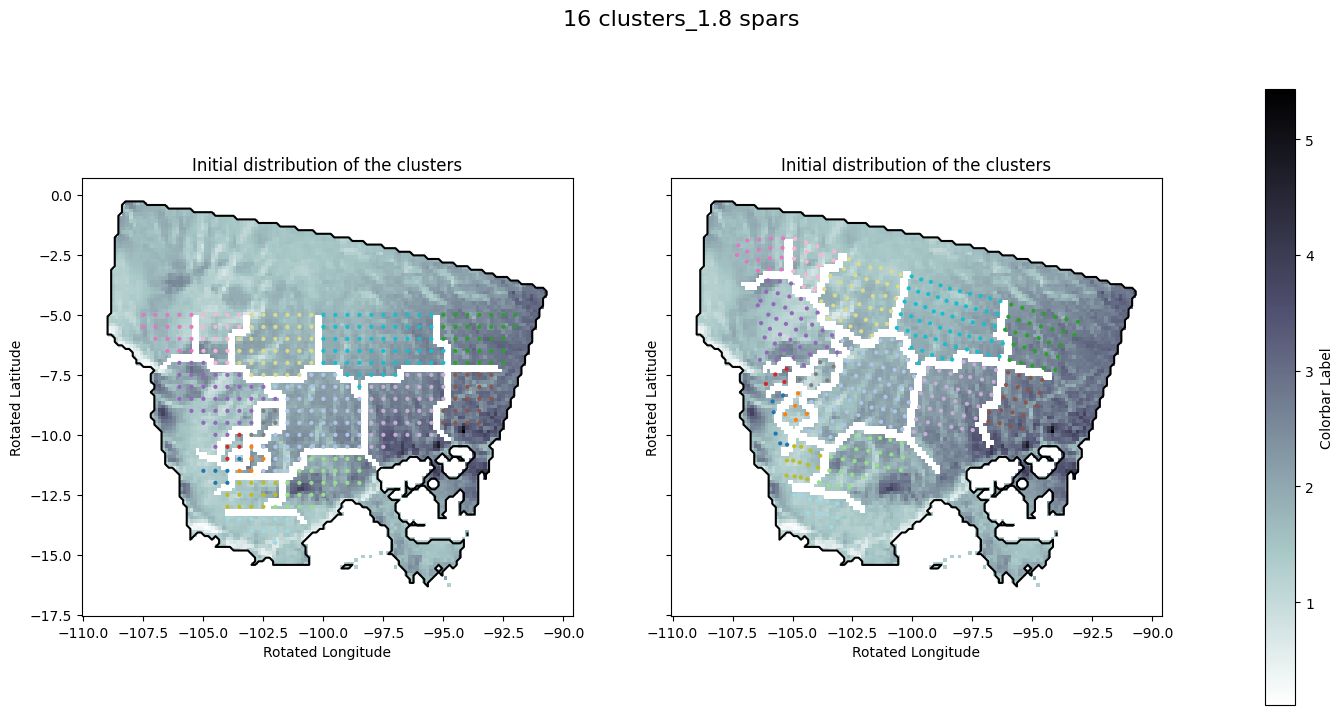

Animation saved to /cluster/projects/nn9970k/lluisa/NextSIM/rotated_ice_velocities/special_cases/beaufort_zoom_lead_febmars/Fmap/ic0.5_dt0.0025_DT0.0250/clustersgeodesic_False_nclusters16_e1.80.gif


0

In [21]:

results_cut(1.8,False,file_path,K,k_exp,sit,distance,land_mask,latitude,longitude)

Reading data
Computing the eigenvalues
The percentage of spercified elements is 0.1813940482020137
[]
(0,) trajectories have been removed because they were not similar to any other trajectories
Computing first 20 eigenvalues
k_means clustering
The default number of clusters is 4


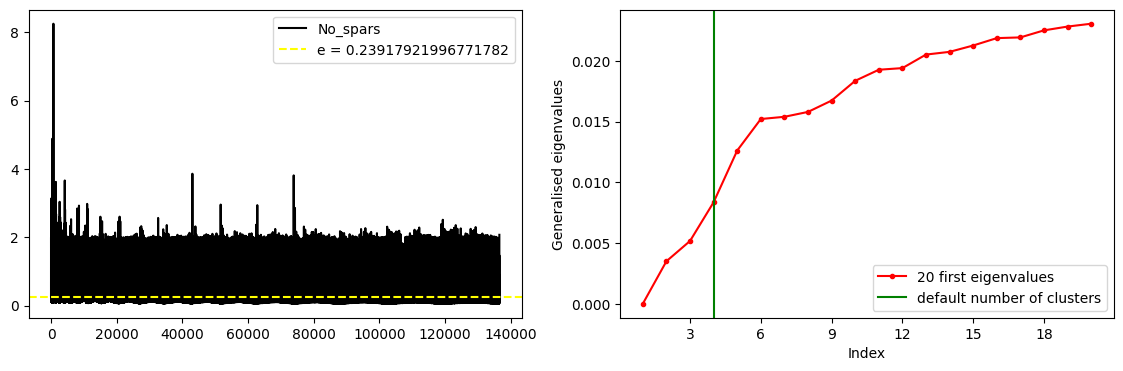

Applying k-means to define the clusters
Plotting the clusters


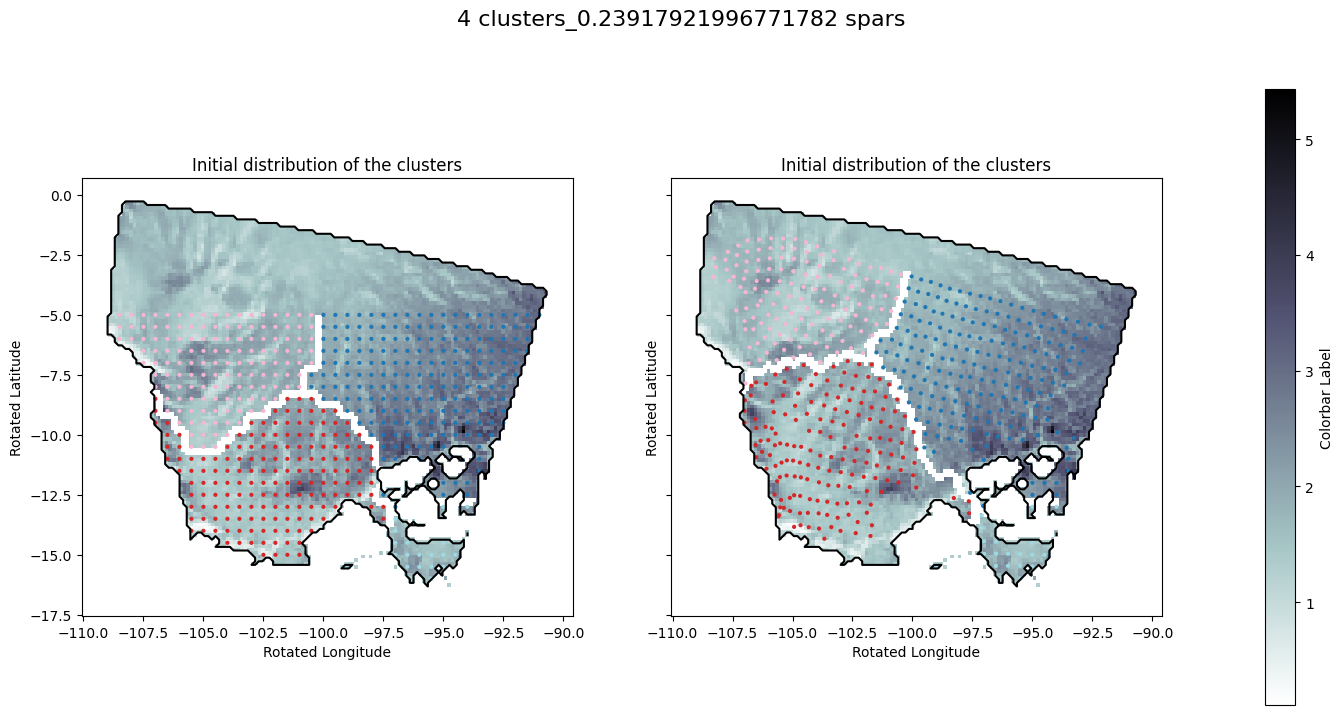

0

In [54]:
results(0,False,file_path,K,k_exp,sit)


Reading data
Computing the eigenvalues
The percentage of spercified elements is 0.19223326953036898
[]
(0,) trajectories have been removed because they were not similar to any other trajectories
Computing first 20 eigenvalues
k_means clustering
The default number of clusters is 4


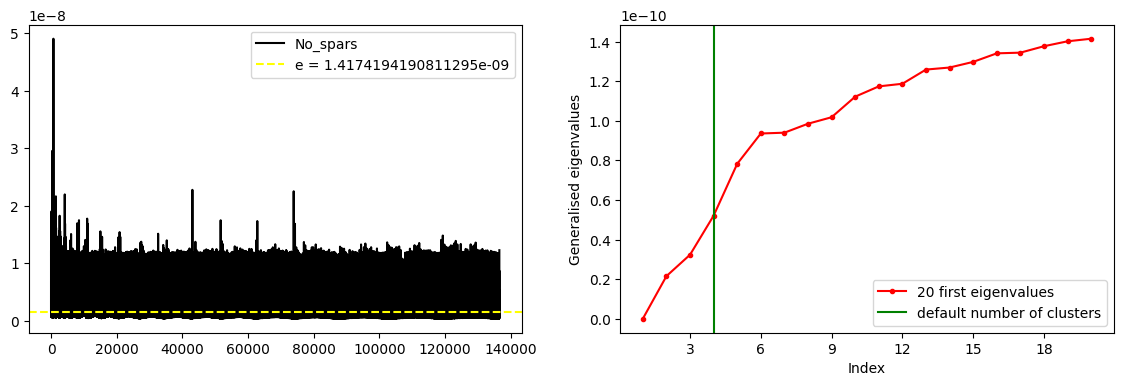

Applying k-means to define the clusters
Plotting the clusters


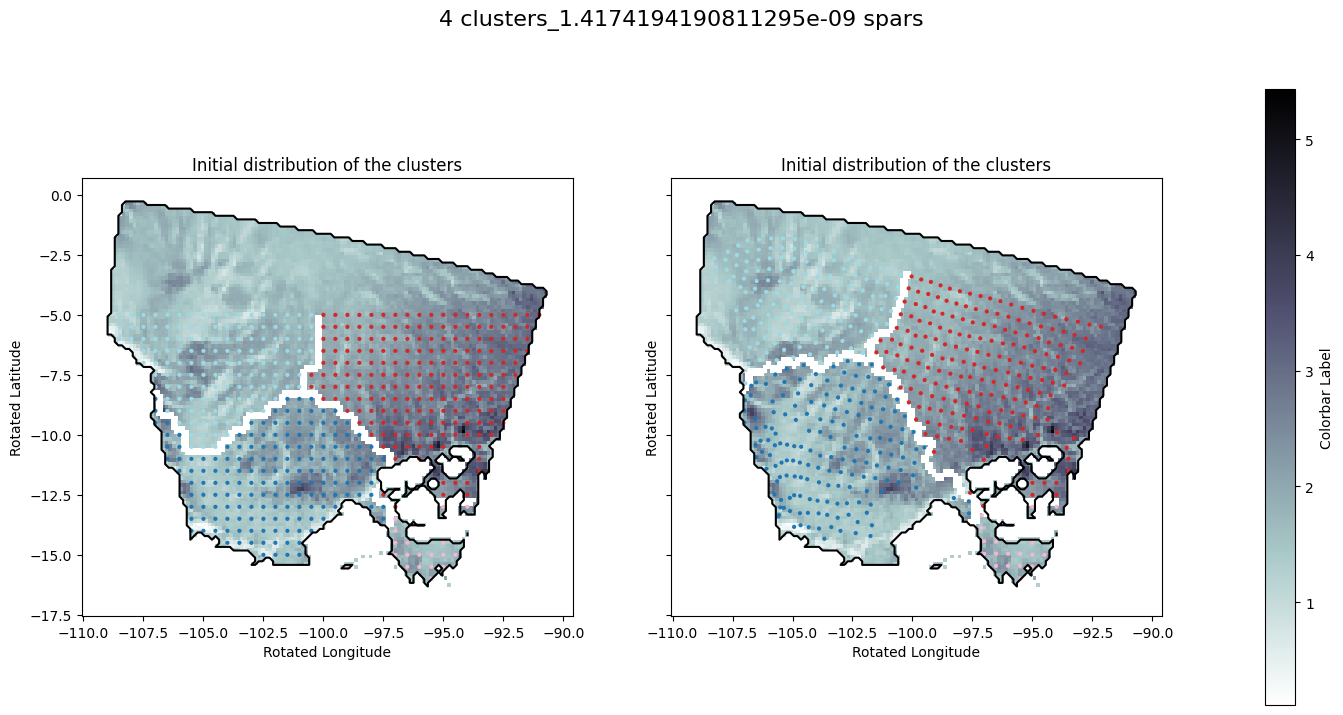

0

In [55]:
results(0,True,file_path,K,k_exp,sit)

Reading data
Computing the eigenvalues
The percentage of spercified elements is 0.2592791586079555
[  1 146 229 291]
(4,) trajectories have been removed because they were not similar to any other trajectories
Computing first 20 eigenvalues
k_means clustering
The default number of clusters is 19


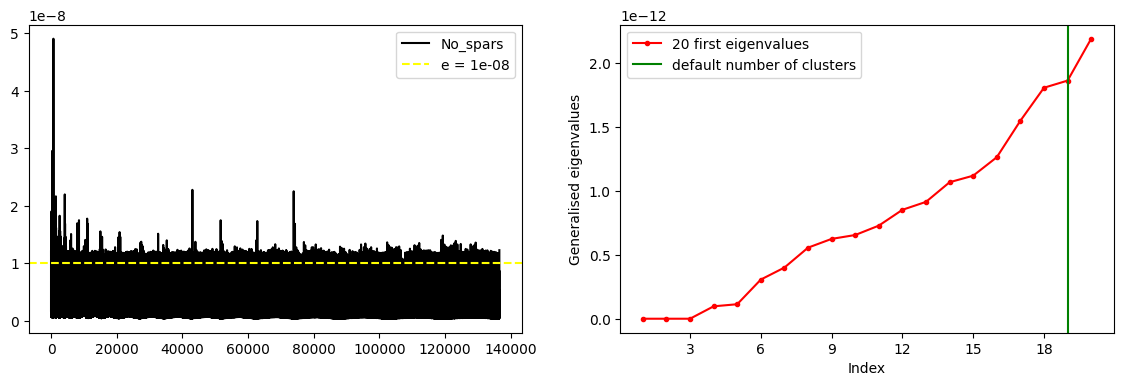

Applying k-means to define the clusters
Plotting the clusters


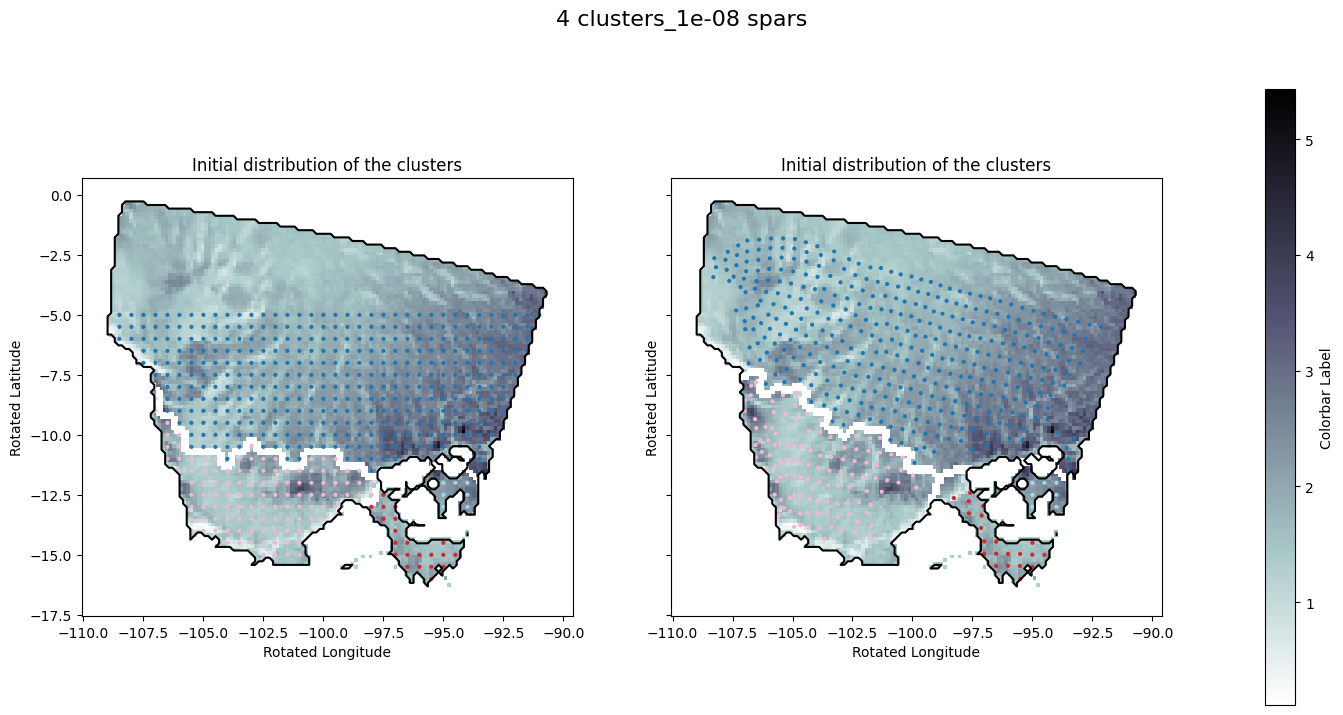

0

In [56]:
results(10 ** -8,True,file_path,K,k_exp,sit)

In [57]:
"""
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
from scipy.interpolate import griddata
from xmovie import Movie  # Assuming xarray.Movie is available
def gif_clusters_landmask_borders_xa(Fmap, n_clusters, labels, img_name, e, x, y, mask_interpol, scalar, freq):
    # Create a DataArray for the frames
    frames = xr.DataArray(scalar, dims=['time', 'dim1', 'dim2'])
    # Define a color map for the clusters
    colors = plt.get_cmap("tab20", n_clusters)
    cluster_names = [f"Cluster {i+1}" for i in range(n_clusters)]  # Names for legend
    # Define color map for the landmask
    colors_mask = [(0.58, 0.747, 0.972), (1, 1, 1)]  # Light blue and white
    custom_cmap = mcolors.LinearSegmentedColormap.from_list("GreyToBlue", colors_mask)
    colors_mask = plt.get_cmap(custom_cmap, 2)
    ymax = y.max()
    ymin = y.min()
    xmax = x.max()
    xmin = x.min()
    # Create a grid for contour plotting
    grid_x, grid_y = np.meshgrid(np.linspace(xmin, xmax, 50), np.linspace(ymin, ymax, 50))
    def animate(da, fig, timestep, framedim, **kwargs):
        ax = fig.add_subplot(111)
        ax.scatter(x.ravel(), y.ravel(), marker='.', s=0.1, c=mask_interpol, cmap=colors_mask)
        positions_i = Fmap[timestep*10, :, :]
        scalar_i = scalar[timestep, :, :]  # Assuming you want to show the first time slice
        grid_labels = griddata((positions_i[0, :], positions_i[1, :]), labels, (x, y), method='nearest')
        fmap_mask = np.isnan(griddata((positions_i[0, :], positions_i[1, :]), labels, (x, y), method='linear'))
        borders = borders_binary(grid_labels)
        borders = np.where(fmap_mask, np.nan, borders)
        borders = np.ma.masked_where(borders == 0, borders)
        im1 = ax.imshow(scalar_i, extent=(xmin, xmax, ymin, ymax), origin='lower', cmap='bone_r',vmin=0,vmax=5)
        ax.pcolormesh(x, y, borders, cmap="Greys", alpha=1)
        scatter_ini = ax.scatter(positions_i[0, :], positions_i[1, :], c=labels, cmap=colors, vmin=0, vmax=n_clusters-1, s=4)
        contour_land = ax.contour(x, y, mask_interpol, levels=0, cmap='bone', alpha=1)
        ax.set_xlabel("Rotated Longitude")
        ax.set_ylabel("Rotated Latitude")
        ax.set_xlim(xmin - 0.05 * (xmax - xmin), xmax + 0.05 * (xmax - xmin))
        ax.set_ylim(ymin - 0.05 * (ymax - ymin), ymax + 0.05 * (ymax - ymin))
        ax.set_aspect('equal', 'box')
        ax.set_title(f"Cluster at timestep {timestep + 1}")
    # Create the movie
    movie = Movie(frames, animate, fps=10, filename=img_name)
    movie.save(img_name, overwrite_existing=True)
    print(f"Animation saved to {img_name}")
# Note: You need to define the `borders_binary` function and ensure `xarray.Movie` is installed.
"""

'\nimport xarray as xr\nimport matplotlib.pyplot as plt\nimport matplotlib.colors as mcolors\nimport numpy as np\nfrom scipy.interpolate import griddata\nfrom xmovie import Movie  # Assuming xarray.Movie is available\ndef gif_clusters_landmask_borders_xa(Fmap, n_clusters, labels, img_name, e, x, y, mask_interpol, scalar, freq):\n    # Create a DataArray for the frames\n    frames = xr.DataArray(scalar, dims=[\'time\', \'dim1\', \'dim2\'])\n    # Define a color map for the clusters\n    colors = plt.get_cmap("tab20", n_clusters)\n    cluster_names = [f"Cluster {i+1}" for i in range(n_clusters)]  # Names for legend\n    # Define color map for the landmask\n    colors_mask = [(0.58, 0.747, 0.972), (1, 1, 1)]  # Light blue and white\n    custom_cmap = mcolors.LinearSegmentedColormap.from_list("GreyToBlue", colors_mask)\n    colors_mask = plt.get_cmap(custom_cmap, 2)\n    ymax = y.max()\n    ymin = y.min()\n    xmax = x.max()\n    xmin = x.min()\n    # Create a grid for contour plotting\n  